# 1. Distortion spherical illumination

## Theory

In [1], there is an explanation of the propagation of a spherical wavefront for DIH. In cases where the source is much farther away from the sensor than from the particles, the paraxial approximation is used. Otherwise, there is a two-step approach where the hologram is propagated first to the source plane, and afterwards to the object plane. But then it says that the reconstruction can be performed with a planar wave. So, both ways involve using the paraxial approximation.

Same for [2] (based on [3]), which uses a paraxial approximation to describe the phase terms of the reference point-source wave, the object wave, and a reconstruction source wave located elsewhere.

## References

- [1] 2015 - Practical algorithms for simulation and reconstruction of digital in-line holograms
- [2] 2019 - Resolution and sampling analysis in digital in-line holography with spherical wave illumination
- [3] Chapter 9.5.1 in J. W. Goodman, Introduction to Fourier Optics, Roberts and Company Publishers, Greenwood Village (2005).

## Simulation of a spherical wavefront hologram

The spherical wavefront is $$\frac{e^{ikr}}{r},$$ with $r = \sqrt{x^2+y^2+z^2}.$
$$\frac{d\phi}{dx} = \frac{kx}{\sqrt{x^2+y^2+z^2}}$$

Maximum step is $\frac{d\phi}{dx}p$ with $\hat{x}=\frac{N_c}{2}p$, $y=0$, and $p$ the pixel pitch. The sampling condition where the phase step is lower than $\pi$ :
$$\frac{k\hat{x}p}{\sqrt{\hat{x}^2+z^2}} < \pi$$
$$p < \frac{\lambda \sqrt{\hat{x}^2 + z^2}}{2\hat{x}}$$

In [1]:
import numpy as np
np.set_printoptions(precision=3)
wavelength = 355e-9
Nr = 8916
Nc = 13264
p = 2.2e-6
L = 65e-3
Ncr = np.array((Nc, Nr))
xhat = Ncr*p/2
# Analysis of illumination
NA = xhat / np.sqrt(xhat**2 + L**2)
print(f'The NA of the system is {NA}')
# Analysis of proper sampling
pmin = wavelength * np.sqrt(xhat**2 + L**2) / 2 / xhat
Nresample = np.floor(2*xhat / pmin)
print(f'Resample at pixel size {pmin/1e-6} um, with {Nresample} pixels. {np.prod(Nresample)/1e6:.1f} Mpx')
# Padding (non zero)
Npad = 2*Ncr
xhat = Npad*p/2
pmin = wavelength * np.sqrt(xhat**2 + L**2) / 2 / xhat
Nresample = np.floor(2*xhat / pmin)
print(f'Resample at pixel size {pmin/1e-6} um, with {Nresample} pixels. {np.prod(Nresample)/1e6:.1f} Mpx')

zopt = L - L**2 * wavelength / Ncr / p**2
print(f'The optimal distance for the object is {zopt/1e-3} mm.')

The NA of the system is [0.219 0.149]
Resample at pixel size [0.81 1.19] um, with [36006. 16487.] pixels. 593.6 Mpx
Resample at pixel size [0.433 0.614] um, with [134661.  63852.] pixels. 8598.4 Mpx
The optimal distance for the object is [41.637 30.243] mm.


Maximum step is $\frac{d\phi}{dx}p$ with $x=\left(\frac{N_c}{2}-1\right)p$, $y=0$, and $p$ the pixel pitch. The minimum distance $z$ at which the step is lower than $\pi$ :
$$\frac{k\left(\frac{N_c}{2}-1\right)p^2}{\sqrt{(\left(\frac{N_c}{2}-1\right)p)^2+z^2}} < \pi$$
$$\left[\left(\frac{N_c}{2}-1\right)p\right]^2 \left[\left(\frac{2p}{\lambda}\right)^2-1\right] = \left[\frac{2}{\lambda}\left(\frac{N_c}{2}-1\right)p^2\right]^2 - \left[\left(\frac{N_c}{2}-1\right)p\right]^2 < z^2$$
$$\frac{N_cp}{2}\sqrt{\left(\frac{2p}{\lambda} \right)^2 - 1} = \sqrt{\left(\frac{kp^2N_c}{2\pi}\right)^2 - \left(\frac{N_cp}{2}\right)^2} < z   \textrm{ or simpler}$$

See `C:\Work\PythonProjects\SphericalIlluminationDistortion\simulate_spherical_asm.py`. There is a distortion in the reconstruction with a planar wavefront.

For a hologram taken at $z=L$ and having $N=\max(N_c,N_r)$ pixels with size $p$, if the condition is not satisfied, there is an interpolation factor $m>1$, such as $N'=mN$ and $p'=p/m$ that would make the sampling possible if ($w=m^{-1}$):
$$\frac{4p^2}{\lambda^2}(w^4-Nw^3) + \left(\frac{N^2p^2}{\lambda^2}-1\right)w^2+Nw-\left(\frac{N^2}{4}+(L/p)^2\right)<0$$

# 2. Using Non-uniform FFT (NUFFT)

## NUFFT types

### Type 1

Nonuniform to uniform.

$$f[k_1] = NUFFT^\pm_1\{c[j],x[j],N_1\} = \sum_{j=0}^{M-1} c[j] \exp(\pm i k_1 x[j]),$$
for $-N_1 \leq k_1 \leq N_1-1$, $-\pi \leq x[j] < \pi.$

### Type 2

Uniform to nonuniform.

$$f[j] = NUFFT^\pm_2\{c[k_1],x[j]\} = \sum_{k_1} c[k_1] \exp(\pm i k_1 x[j]),$$
for $j = 0, \dots, M-1$, $-\pi \leq x[j] < \pi.$

### Type 3

Nonuniform to nonuniform.

$$f[k] = NUFFT^\pm_3\{c[j],x[j],s[k]\} = \sum_{j=0}^{M-1} c[j] \exp(\pm i s[k] x[j]),$$
for $k = 0, \dots, N-1$.

## Band-limited ASM (BLASM)

Usual ASM propagation of a hologram $H(j,k)$ obtained with a collimated beam is 
$$u_2(p,q) = FFT^{-1}\{FFT\{H(j,k) R(j,k)\} K(u,v)\},$$
with $R(j,k) = 1$ and $$K(u,v) = \exp\left(2\pi iz\sqrt{\lambda^{-2} - u^2 - v^2}\right),$$ with $z$ the distance from the hologram to the reconstruction plane.

In band-limited ASM, $K(u,v)=0$ for pairs $(u,v)$ where the phase of $K(u,v)$ is not sampled properly (difference between consecutive pixels is $>\pi$).

There are 2 options for the reconstruction when a divergent beam is used for getting the hologram at distance $L$ from a point source:
1. keep using $R=1$ but consider the magnification $m=L/(L-z)$ for reconstructing at distance $z' = mz$ and considering the effective pixel size of the reconstruction as $\Delta' = \Delta/m$, where $\Delta$ is the pixel size of the hologram.
2. use $R(j,k) = e^{-2\pi i \sqrt{(j\Delta)^2 + (k\Delta)^2 + L^2}}$, but the illuminated area gets smaller when $z\rightarrow L$. It would be better to reconstruct a scaled image with pixel size $\Delta/m$.

Option 1 introduces the paraxial approximation and therefore some distortion occurs when NA is high (far from the center area). Option 2 requires a significant upsampling of the hologram to correctly represent the spherical wavefront. An irregular sampling of the input plane may solve this issue.

## BLASM with irregular sampling of the input

The spherical wavefront that is used to illuminate the hologram before reconstruction needs very small pixels in regions far from the center. It is convenient in terms of memory requirements to sample the input plane with an irregular grid. So, the spectrum of the input is

$$A(u, v, 0) = \iint u_1(x_1, y_1) e^{-2\pi i (x_1 u + y_1 v)},$$
where $u_1(x_1, y_1)$ is the numerically illuminated hologram, and $x_1, y_1$ are irregularly sampled. The frequency may be sampled irregularly or not.

### Regular sampling in frequency - Band limited ASM

$$A(m, n, 0) = \sum_{j,k} u_1(x_{1j}, y_{1k}) \exp\left(-2\pi i (x_{1j} m \Delta u + y_{1k} n \Delta v)\right)$$

If the input region is bound to $x_1 \in [-\alpha_x, \alpha_x)$ and $y_1 \in [-\alpha_y, \alpha_y)$, then, according to "Zhang, W., Zhang, H., & Jin, G. (2020). Adaptive-sampling angular spectrum method with full utilization of space-bandwidth product. Optics Letters, 45(16), 4416-4419", the sampling in frequency has to be $\Delta u = 1/4\alpha_x$ and $\Delta v = 1/4\alpha_y$ to avoid the need of zero-padding (case I in the paper, refers to band-limited ASM). 

The maximum spatial frequencies are determined by the maximum value given by the conditions:
1. the maximum spatial frequency given by the smallest step in the irregular sampling of the numerically illuminated input;
2. frequency where the band-limited ASM condition is met (propagation kernel well sampled).

These conditions are analysed in a following section.

Type-1 NUFFT requires the exponential term to be $e^{-i k x'}$, so $x'_j = \frac{\pi}{2\alpha_x} x_{1j}$, $y'_k = \frac{\pi}{2\alpha_y} y_{1k}$. $x'_j$ and $y'_k$ are guaranteed to be in $[-\pi, \pi)$. Thus,

$$\begin{align}
A(m, n, 0) &= \sum_{j,k} u_1(x_{1j}, y_{1k}) \exp\left(-2\pi i (x'_j \frac{2\alpha_x}{\pi} m (4\alpha_x)^{-1} + y'_k \frac{2\alpha_y}{\pi} n (4\alpha_y)^{-1})\right)\\
&= \sum_{j,k} u_1 \exp\left(-i (x'_j m + y'_k n)\right)\\
&= NUFFT_1^-\{u_1, (x'_j, y'_k), (2J, 2K)\}.
\end{align}$$

As the propagation kernel is well sampled for the chosen values of spatial frequencies for the propagation distance $z$,
$$A(m, n, z) = A(m, n, 0) \exp\left(2\pi i z\sqrt{\frac{1}{\lambda^2}- (m\Delta u)^2 - (n\Delta v)^2}\right),$$

$$u_2(x_2, y_2) = \sum_{m, n} A(m, n, z) \exp\left(2\pi i (x_{2p} m \Delta u + y_{2q} n \Delta v)\right).$$

Given the output sampling pixel with size $\Delta_2$ ($x_{2p} = p\Delta_2$, $y_{2q} = q\Delta_2$), the exponential term is $\pi i (p m / 2\alpha_x + q n / 2\alpha_y) \Delta_2$, with $-P \leq p < P$, $-Q \leq q < Q$. The Type-2 NUFFT is used for calculating this summation, so the output locations $x'_p = \frac{\pi}{2\alpha_x} p \Delta_2$ and $y'_q = \frac{\pi}{2\alpha_y} q \Delta_2$:
$$u_2(x_2, y_2) = NUFFT_2^+\{A(m, n, z), (x'_p,y'_q) \}$$

As they have to be in $[-\pi,\pi)$, $p_{\max} = 2\alpha_x/\Delta_2$ and $q_{\max} = 2\alpha_y/\Delta_2$. This means that the output cannot be larger than double the input, so it is constrained for simulations.

#### Maximum spatial frequency conditions

For **condition 1** we consider that the irregular sampling of the input is done in $x$ and $y$ separatedly, so the phase of the spherical illumination wave is $\phi = k\sqrt{x_j^2 + z_i^2}$, where $z_i$ is the distance between the source and the input plane. The derivative of $\phi$ has its maximum value for $x = \alpha_x$, so the condition can be written as $\left|\frac{\partial \phi}{\partial x}\right|_{x=\alpha_x} \hat{\Delta}x = \pi$, where $\hat{\Delta}x$ is the smallest sampling step.

So the maximum $m$, $M$, is the one that gets $M \Delta u = \pi / \hat{\Delta}x$. So, $M = \frac{\pi}{\hat{\Delta}x \Delta u} = \frac{\left|\frac{\partial \phi}{\partial x}\right|_{x=\alpha_x}}{\Delta u}$:
$$M = \frac{2(2\alpha_x)^2\pi}{\lambda\sqrt{\alpha_x^2 + z_i^2}}$$

**Condition 2** gives an $m_\lim$ for which the kernel can be calculated. If $M > m_\lim$, then the kernel is set to 0 for $m > m_\lim$. There is also an $n_\lim$ so that an ellipse can be defined for the band-limited calculation of the 2D kernel. In 1D, the phase of the kernel is $\phi_K = 2\pi z \sqrt{\lambda^{-2} - (m\Delta u)^2}$, so the condition is expressed as
$$\left|\frac{\partial \phi_K}{\partial m}\right|_{m=m_\lim} = \pi.$$

Which gives
$$m_\lim = \frac{1}{\lambda\Delta u\sqrt{4z^2\Delta u^2 + 1}}.$$

Using $\Delta u = \frac{1}{4\alpha_x}$,
$$m_\lim = \frac{8 \alpha_x^2}{\lambda \sqrt{z^2 + 4\alpha_x^2}}.$$

#### Using NUFFT type-3

The use of type-3 NUFFT simplifies the calculations as there are no variable changes and constraints for the inputs (spatial coordinates and spatial frequencies).

$$A(m, n, 0) = NUFFT_3^-\{u_1, (x_{1j}, y_{1k}), s(m, n)\},$$
using $s(m, n) = 2\pi (m \Delta u, n \Delta v)$.

And then $$u_2(x_2, y_2) = NUFFT_3^+\{A(m, n, z),s(m, n),(x_2, y_2)\},$$ with $(x_2, y_2) = (p, q) \Delta_2.$

## Simulation

A hologram is simulated by using a small setup (4mm from source to sensor, 4 small round objects in plane z=2mm). The small setup allows using a manageable amount (3000 x 3000) of very small pixels, which allow sampling the spherical wavefront of the divergent beam.

<img src="distortion_files\simulated_hologram.png" alt="Drawing" style="height: 400px;"/>

The hologram is reconstructed by using option 1 (ASM with paraxial approximation) and option 2 (BLASM with irregular sampling).

<img src="distortion_files\No contrast (Holosuite)\Reconstruction_BLASM_irregular_small_setup.png" alt="Drawing" style="height: 500px;"/>

The hologram can be downsampled to simulate the use of a sensor with larger pixels. Here I show the reconstructions with the 2 options for the downsampling by 2 and by 5. In the third case (downsample by 5), the reconstruction used 126.5 % of pixels.
The amount of pixels required for a proper regular sampling of the illumination spherical wavefront is 265.8 % of the original.

<img src="distortion_files\No contrast (Holosuite)\Reconstruction_BLASM_irregular_small_setup_downsampling2.png" alt="Drawing" style="height: 500px;"/>

<img src="distortion_files\No contrast (Holosuite)\Reconstruction_BLASM_irregular_small_setup_downsampling5.png" alt="Drawing" style="height: 500px;"/>

As I couldn't solve the border effect with proper padding (as did for the paraxial case), I also tried with contrast holograms (background subtracted).

<img src="distortion_files\simulated_contrast_image.png" alt="Drawing" style="height: 400px;"/>

<img src="distortion_files\Contrast\Reconstruction_BLASM_irregular_small_setup_contrast.png" alt="Drawing" style="height: 500px;"/>

<img src="distortion_files\Contrast\Reconstruction_BLASM_irregular_small_setup_contrast_downsampling2.png" alt="Drawing" style="height: 500px;"/>

<img src="distortion_files\Contrast\Reconstruction_BLASM_irregular_small_setup_contrast_downsampling5.png" alt="Drawing" style="height: 500px;"/>

### Kirchhoff-Helmholtz integral

In DIHM (digital inline holographic microscopy), the sample is placed close to point source to obtain a high geometrical magnification effect, and the Kirchhoff-Helmholtz integral (KHI) is usually employed instead of ASM. Here I show the result of using the KHI for the contrast hologram with downsampling of 5 (slower than ASM). 

<img src="distortion_files\Contrast\KH_down5_contrast.png" alt="Drawing" style="height: 300px;"/>

KHI behaves awfully when the sample is not close to the point source. In fact, there are papers (the ones cited in section 1) that show that the resolution and sampled volume may be improved if the sample is placed in an optimal z location, not necessarily being close to the point source. So, the ASM with irregular sampling solves the distortion issue and works better and faster than the KHI at the optimal resolution distances of reconstruction.

## Band-extended ASM

Instead of using a fixed sampling in frequency and making the kernel null outside the band-limit, the sampling in frequency is adapted to keep the same amount of pixels inside the properly sampled kernel. This way, the limit is pushed away (extended).

First, we need to see if the propagation distance $z > z_c$, the critical distance that causes improper sampling of the kernel phase. The kernel phase for $z_c$ satisfies:
$$\left|\frac{\partial \phi}{\partial u}\right|_{u=\frac{1}{2\Delta x}}\Delta u = \pi \;\mbox{  and  }\; \left|\frac{\partial \phi}{\partial v}\right|_{v=\frac{1}{2\Delta y}}\Delta v = \pi,$$
with $\phi = 2\pi z \sqrt{\lambda^{-2} - u^2 - v^2}.$ So, $z_c = \min(z_{cx}, z_{cy})$ with
$$z_{cx} = \frac{\Delta x}{\Delta u}\sqrt{\lambda^{-2}-(2\Delta x)^{-2} - (2\Delta y)^{-2}},$$
$$z_{cy} = \frac{\Delta y}{\Delta v}\sqrt{\lambda^{-2}-(2\Delta x)^{-2} - (2\Delta y)^{-2}}.$$
Note that $\Delta x$ and $\Delta y$ are the minimum steps between samples if irregular sampling is used for the input.

If $z<=z_c$, then the maximum frequencies are $\hat{u} = \frac{1}{2\Delta x}$ and $\hat{v} = \frac{1}{2\Delta y}$.

If $z>z_c$, then we'll use the same amount of samples $4J\times 4K$ (the input has $2J\times 2K$ samples, but the double is needed to avoid circularity effects) but with an adapted size so that only the extended bandwidth is sampled. If we allow the limit frequencies to be $\hat{u}$ and $\hat{v}$, and the frequency sampling pitches $\Delta u = \frac{\hat{u}}{2J}$ and $\Delta v = \frac{\hat{v}}{2K}$, then the sampling condition at $\hat{u}$ and $\hat{v}$ are
$$\frac{z\lambda \hat{u}^2}{J\sqrt{1-(\lambda\hat{u})^2}} = 1 \;\Rightarrow\; \left(\frac{z\lambda}{J}\right)^2 \hat{u}^4 + \lambda^2 \hat{u}^2 - 1 = 0 \mbox{ and for }\hat{v}\mbox{ is } \left(\frac{z\lambda}{K}\right)^2 \hat{v}^4 + \lambda^2 \hat{v}^2 - 1 = 0.$$
We obtain the frequency limits by solving these equations, that also give us $\Delta u$ and $\Delta v$.

Then we apply the same ASM based on NUFFT type-1 and NUFFT type-2 scheme as did for the band-limited ASM. So, going back to
$$A(m, n, 0) = \sum_{j,k} u_1(x_{1j}, y_{1k}) \exp\left(-2\pi i (x_{1j} m \Delta u + y_{1k} n \Delta v)\right) = \sum_{j,k} u_1 \exp\left(-2\pi i (x_{1j} m \frac{\hat{u}}{2J} + y_{1k} n \frac{\hat{v}}{2K})\right),$$
we use $x'_j = \frac{\pi\hat{u}}{J}x_{1j}$ and $y'_k = \frac{\pi\hat{v}}{K}y_{1k}$, both $\in [-\pi,\pi)$:
$$A(m, n, 0) = NUFFT^-_1\{u_1, (x'_j, y'_k), (2J, 2K)\} = \sum_{j,k} u_1 e^{-i (x'_{1j} m + y'_{1k} n)}.$$

The propagation kernel is well sampled only within the ellipse with width $2\hat{u}$ and height $2\hat{v}$. Inside the ellipse,
$$A(m, n, z) = A(m, n, 0) \exp\left(2\pi i z\sqrt{\lambda^{-2}- (m\Delta u)^2 - (n\Delta v)^2}\right),$$

$$u_2(x_2, y_2) = \sum_{m, n} A(m, n, z) \exp\left(2\pi i (x_{2p} m \Delta u + y_{2q} n \Delta v)\right).$$

Given the output sampling pixel with size $\Delta_2$ ($x_{2p} = p\Delta_2$, $y_{2q} = q\Delta_2$), the exponential term is $\pi i (p m \hat{u}/J + q n \hat{v}/K) \Delta_2$, with $-P \leq p < P$, $-Q \leq q < Q$. The Type-2 NUFFT is used for calculating this summation, so the output locations $x'_p = p \frac{\pi\hat{u}}{J} \Delta_2$ and $y'_q = q \frac{\pi\hat{v}}{K} \Delta_2$:

$$u_2(x_2, y_2) = NUFFT_2^+\{A(m, n, z), (x'_p,y'_q) \}$$

As $(x'_p,y'_q)$ have to be in $[-\pi,\pi)$, $P \leq J/\hat{u}\Delta_2$ and $Q \leq K/\hat{v}\Delta_2$. The largest possible value of $\hat{u}$ is $1/2\Delta x$ at $z=z_c$, as $\hat{u}$ decreases for higher $z$, then $P_{\max} \geq 2J\Delta x/\Delta_2$ This means that the output cannot be larger than double the input, so simulations are constrained.


# 3. Other possible ways of working with spherical wavefront

## Reconstruction using numerical lens

*2015 - Pixel size adjustment in coherent diffractive imaging within the Rayleigh–Sommerfeld regime*

Trying to reduce the distortion effect by using the closest spherical wavefront that the sampling of the camera allows. Applied to `C:\Work\PythonProjects\SphericalIlluminationDistortion\sim_setup_numerical_lens.py`

## Propagation of high resolution images

*2010 - Fast exact scalar propagation for an in-line holographic microscopy on the diffraction limit*

It separates the hologram in tiles and Fourier transforms each of them, then a large iFFT is needed for getting the complete reconstruction.

It works for reconstruction but it doesn't work for simulation propagation.

## Simulation of 3 setups

### Photron

1024 x 1024, 20e-6 m pixel size. L = 90mm, z = 80mm. Wavelength 532 nm.

The interpolation factor for simulating the object plane (with padding) is 67.5.

# 4. Simulation with magnification >2 using scaled ASM

In this case, $|x_2|_\max > |x_1|_\max$, so $R_x = \frac{|x_2|_\max}{|x_1|_\max} > 1$. The output is sampled as $x_{2p} = p\Delta_2$, with $-P \leq p < P$ (similar for $y_{2q}, R_y, Q$). If I want 

$$u_2(p,q) = FFT^{-1}\{A(m,n,z)\},$$

then $\Delta u = 1/2|x_2|_\max$ and $\Delta v = 1/2|y_2|_\max$, $M=P$, and $N=Q$. Then,

$$\begin{align}
A(m, n, 0) &= \sum_{j,k} u_1(x_{1j}, y_{1k}) \exp\left(-2\pi i (x_{1j} m / 2|x_2|_\max + y_{1k} n / 2|y_2|_\max)\right) = \sum_{j,k} u_1 \exp\left(-\pi i (x_{1j} m / |x_2|_\max + y_{1k} n / |y_2|_\max)\right) \\
&= \sum_{j,k} u_1 \exp\left(-\pi i (\tilde{x}_{1j} m / R_x + \tilde{y}_{1k} n / R_y)\right) = \sum_{j,k} u_1 \exp\left(-i (x'_j m + y'_k n)\right) \\
&= NUFFT^-_1\{u_1, (x'_j, y'_k), (P, Q)\}
\end{align}$$

where $\tilde{x}_{1j} = x_{1j} / |x_1|_\max$, and $x'_j = \frac{\pi}{R_x}\tilde{x}_{1j}$ (similar for $y$), $x'_j\in [-\pi,\pi)$.

Now, we need to find the band limits $\hat{u}, \hat{v}$ that guarantee a well sampled propagation kernel. Again, the condition of phase change equal to $\pi$:
$$\frac{2\lambda z \hat{u} \Delta u}{\sqrt{1 - (\lambda \hat{u})^2}} = 1 \;\Rightarrow\; \hat{u} = \frac{1}{\lambda\sqrt{(2 z \Delta u)^2 + 1}} = \frac{1}{\lambda\sqrt{\left(\frac{z}{P \Delta_2}\right)^2 + 1}}$$
$$\frac{2\lambda z \hat{v} \Delta v}{\sqrt{1 - (\lambda \hat{v})^2}} = 1 \;\Rightarrow\; \hat{v} = \frac{1}{\lambda\sqrt{(2 z \Delta v)^2 + 1}} = \frac{1}{\lambda\sqrt{\left(\frac{z}{Q \Delta_2}\right)^2 + 1}}$$

Inside the band limit given by $\hat{u}, \hat{v}$,
$$A(m, n, z) = A(m, n, 0) \exp\left(2\pi i z\sqrt{\lambda^{-2}- (m\Delta u)^2 - (n \Delta v)^2}\right).$$

## NUFFT considerations

The NUFFT of $c_j$ first interpolates $c$ over a grid in $[-\pi, \pi)$ using a kernel $\psi$ and $2N$ points, being $N$ the amount of output frequencies. As $R$ increases, the $x'_j$ cover a smaller portion of $[-\pi, \pi)$, and less points of the interpolation grid fall into the locations of $x'_j$. There are 2+1 ways of dealing with this:
1. Use $R$ more points of frequency with smaller $\Delta u$ ($\hat{u}$ increases). Downsample the output.
2. Spread $x'_j$ by multiplying by $R$, which means that the obtained frequencies will be evaluated at $R$ times the wanted frequencies. We'll need to extract (interpolate, loss of info) the first $1/R^{th}$ portion of the output before applying propagation kernel. $\hat{u}$ wouldn't change.
3. Merge: Spread $x'_j$ so that the sampling in frequency is $R$ times higher, but also ask for $R$ more outputs so that the actual frequency sampling stays the same, giving the same $\hat{u}$. 

## Doubling frequency sampling rate

Now, I want $\Delta u = 1/4|x_2|_\max$ and $\Delta v = 1/4|y_2|_\max$. So, the output is sampled as $x_{2p} = p\Delta_2$, with $-2P \leq p < 2P$, but we only keep the central part, and

$$u_2(p,q) = FFT^{-1}\{A(m,n,z)\},$$

with $M=2P$, and $N=2Q$. Then,

$$\begin{align}
A(m, n, 0) &= \sum_{j,k} u_1(x_{1j}, y_{1k}) \exp\left(-2\pi i (x_{1j} m / 4|x_2|_\max + y_{1k} n / 4|y_2|_\max)\right) = \sum_{j,k} u_1 \exp\left(-\pi i (x_{1j} m / 2|x_2|_\max + y_{1k} n / 2|y_2|_\max)\right) \\
&= \sum_{j,k} u_1 \exp\left(-\pi i (\tilde{x}_{1j} m / 2R_x + \tilde{y}_{1k} n / 2R_y)\right) = \sum_{j,k} u_1 \exp\left(-i (x'_j m + y'_k n)\right) \\
&= NUFFT^-_1\{u_1, (x'_j, y'_k), (2P, 2Q)\}
\end{align}$$

where $\tilde{x}_{1j} = x_{1j} / |x_1|_\max$, and $x'_j = \frac{\pi}{2R_x}\tilde{x}_{1j}$ (similar for $y$), $x'_j\in [-\pi,\pi)$.

Now, we need to find the band limits $\hat{u}, \hat{v}$ that guarantee a well sampled propagation kernel. Again, the condition of phase change equal to $\pi$:
$$\frac{2\lambda z \hat{u} \Delta u}{\sqrt{1 - (\lambda \hat{u})^2}} = 1 \;\Rightarrow\; \hat{u} = \frac{1}{\lambda\sqrt{(2 z \Delta u)^2 + 1}} = \frac{1}{\lambda\sqrt{\left(\frac{z}{2P \Delta_2}\right)^2 + 1}}$$
$$\frac{2\lambda z \hat{v} \Delta v}{\sqrt{1 - (\lambda \hat{v})^2}} = 1 \;\Rightarrow\; \hat{v} = \frac{1}{\lambda\sqrt{(2 z \Delta v)^2 + 1}} = \frac{1}{\lambda\sqrt{\left(\frac{z}{2Q \Delta_2}\right)^2 + 1}}$$

Inside the band limit given by $\hat{u}, \hat{v}$,
$$A(m, n, z) = A(m, n, 0) \exp\left(2\pi i z\sqrt{\lambda^{-2}- (m\Delta u)^2 - (n \Delta v)^2}\right).$$

# 5. Propagation to upsampled output using scaled ASM

In this case, $|x_2|_\max > |x_1|_\max$, so $R_x = \frac{|x_2|_\max}{|x_1|_\max} > 1$. The output is sampled as $x_{2p} = p\Delta_2$, with $-P \leq p < P$ (similar for $y_{2q}, R_y, Q$). If I want 

$$u_2(p,q) = FFT^{-1}\{A(m,n,z)\},$$

then $\Delta u = 1/2|x_2|_\max$ and $\Delta v = 1/2|y_2|_\max$, $M=P$, and $N=Q$. Then,

$$\begin{align}
A(m, n, 0) &= \sum_{j,k} u_1(x_{1j}, y_{1k}) \exp\left(-2\pi i (x_{1j} m / 2|x_2|_\max + y_{1k} n / 2|y_2|_\max)\right) = \sum_{j,k} u_1 \exp\left(-\pi i (x_{1j} m / |x_2|_\max + y_{1k} n / |y_2|_\max)\right) \\
&= \sum_{j,k} u_1 \exp\left(-\pi i (\tilde{x}_{1j} m / R_x + \tilde{y}_{1k} n / R_y)\right) = \sum_{j,k} u_1 \exp\left(-i (x'_j m + y'_k n)\right) \\
&= NUFFT^-_1\{u_1, (x'_j, y'_k), (P, Q)\}
\end{align}$$

where $\tilde{x}_{1j} = x_{1j} / |x_1|_\max$, and $x'_j = \frac{\pi}{R_x}\tilde{x}_{1j}$ (similar for $y$), $x'_j\in [-\pi,\pi)$.

Now, we need to find the band limits $\hat{u}, \hat{v}$ that guarantee a well sampled propagation kernel. Again, the condition of phase change equal to $\pi$:
$$\frac{2\lambda z \hat{u} \Delta u}{\sqrt{1 - (\lambda \hat{u})^2}} = 1 \;\Rightarrow\; \hat{u} = \frac{1}{\lambda\sqrt{(2 z \Delta u)^2 + 1}} = \frac{1}{\lambda\sqrt{\left(\frac{z}{P \Delta_2}\right)^2 + 1}}$$
$$\frac{2\lambda z \hat{v} \Delta v}{\sqrt{1 - (\lambda \hat{v})^2}} = 1 \;\Rightarrow\; \hat{v} = \frac{1}{\lambda\sqrt{(2 z \Delta v)^2 + 1}} = \frac{1}{\lambda\sqrt{\left(\frac{z}{Q \Delta_2}\right)^2 + 1}}$$

Inside the band limit given by $\hat{u}, \hat{v}$,
$$A(m, n, z) = A(m, n, 0) \exp\left(2\pi i z\sqrt{\lambda^{-2}- (m\Delta u)^2 - (n \Delta v)^2}\right).$$


# 5. Compact Spatial Bandwidth product (CSW) ASM

Kozacki, T., & Falaggis, K. (2016). Angular spectrum method with compact space–bandwidth: generalization and full-field accuracy. Applied optics, 55(19), 5014-5024.

## CSW-ASM

The defocused field $u(x)$ is compressed by doing:
$$u_c = u \exp\left(\pm\frac{i\pi x^2}{\lambda z_c}\right),$$
where the positive sign of the virtual paraxial spherical wave represents a diverging wave. The defocused field is the input when propagating towards a smaller domain and it's the output when propagating towards a more spread domain. The value of $z_c$ is selected to minimize the SW, and in our defocusing case $z_c=L$, where $L$ is the distance from the point source to the sensor.

### Focusing case (reconstruction)

Propagation from plane 1 to 2:
$$\tilde{u}_2(f_2) = H_c(f_2,z_1,z_{c1}) \times \int \tilde{u}_{c1} \exp\left( i\pi\lambda z_{c1} (f_1^2 - 2f_1f_2) \right) df_1,$$
where $\tilde{u}$ represents the Fourier transform, and
$$H_c(f_2,z_1,z_{c1}) = \exp\left( i kz_1 \sqrt{1-(\lambda f_2)^2} + i \pi \lambda z_{c1} f_2^2 \right).$$

The effect of multiplying the output of the $\lambda z_{c1}$ FT and $H_c(f_2,z_1,z_{c1})$ is a requirement of a higher domain in $f_1$. Given a $B_{x_2}^\lim$, the bandwidth is limited at $B_{f_1}^\lim = N/2B_{x_2}^\lim$, and so the extended $B_{f_1}^\lim$ is 
$$B_{f_1}' = 2\left[\frac{B_{x_1}^\lim - B_{x_2}^\lim}{2} \frac{1}{\lambda \sqrt{z_1^2 + \left(\frac{B_{x_1}^\lim - B_{x_2}^\lim}{2}\right)^2}} - B_{x_1}^\lim/(2\lambda z_{c1})\right].$$

And the $f_1$ chirp affecting $\tilde{u}_{c1}$ requires the extension $B_{x_1}' = B_{x_1}^\lim + \lambda z_{c1}B_{f_1}'$.

To reduce Gibbs errors, it's better to extend $B_{f_1}'$ even more.


### Defocusing case (simulation)

Propagation from plane 2 to 3 ($z_{c3}$ is positive, but using compression by converging wave - added negative sign):
$$\tilde{u}_{c3}(f_3) = \exp\left( i\pi \lambda z_{c3}f_3^2 \right) \times \int \tilde{u}_{2}(f_2) H_c(f_2,z_2,z_{c3}) \exp\left[ -2\pi i\lambda z_{c3} (f_2f_3) \right] df_2,$$
where $\tilde{u}$ represents the Fourier transform, and
$$H_c(f_2,z_2,z_{c3}) = \exp\left( i kz_2 \sqrt{1-(\lambda f_2)^2} + i \pi \lambda z_{c3} f_2^2 \right).$$

The effect of multiplying $\tilde{u}_{2}(f_2) \times H_c(f_2,z_2,z_{c3})$ is a requirement of a higher spatial domain in the focus (initial) plane. Given a sampling $\Delta x_2$, the bandwidth is limited at $B_{f_2}^\lim = 1/N\Delta x_2$, and so the maximum extension in $B_{x_2}^\lim$ is $z_2f_2(\lambda^{-2}-f_2^2)^{-1/2} - \lambda z_{c3}f_2$ evaluated at $f_2=B_{f_2}^\lim/2$. Resulting in $B_{x_2}'$.

The scaled FT defines a $B_{f_3}' = B_{x_2}'/\lambda z_{c3}$. Then, the multiplication by the chirp after the integral (in $f_3$) extends the spatial content in $f_2$ (convolution in $f_2$), as well as in $x_3$. Given the linear chirp, $B_{f_2}' = B_{f_2}^\lim + B_{f_3}' = B_{f_2}^\lim + \lambda^{-2}z_{c3}^{-2}B_{x_2}'$.

Both extensions are performed by zero-padding. The $B_{x_2}'$ extension can be increased by 10% to reduce Gibbs errors.

### Numerical implementation with FFTs

3 FFTs of size $N$:
- Focusing:
    1. Fourier transform of the compressed input.
    2. Fourier transform to calculate the Fourier transformed output.
    3. Inverse Fourier transform.
- Defocusing:
    1. Fourier transform of the input.
    2. Fourier transform to calculate the Fourier transformed compressed output.
    3. Inverse Fourier transform.
    
The step 2 requires:
- Focusing: $\Delta x_2 = \frac{\lambda z_{c1}}{N\Delta x_1}$
- Defocusing: $\Delta x_3 = \frac{\lambda z_{c3}}{N\Delta x_2}$

In [1]:
# Calculation of sampling rate at the object plane to generate a hologram for a given camera.
N = 1024
pixel = 20e-6
wavelength = 355e-9
L = 70e-3
object_plane_pixel = wavelength * L / N / pixel
print(f'The object plane should be sampled using a pixel size of {object_plane_pixel/1e-6:.2f} um.')
print(f'We would be simulating an extent of {N*object_plane_pixel/1e-3:.2f} mm.')

The object plane should be sampled using a pixel size of 1.21 um.
We would be simulating an extent of 1.24 mm.


## Generalized CSW-ASM

There are two propagations from a defocused plane 1 to another in 3. There is a focus plane (2) somewhere in the middle. First propagation distance is $z_1$, and then $z_2$.
$$\tilde{u}_{c3} = \exp(i\pi \lambda z_{c3}f_3^2) \int H_c(f_2,z,z_c) \int \tilde{u}_{c1}(f_1) \exp\left[ i\pi \lambda z_{c1}(f_1^2-2f_1f_2) \right] df_1 \times\\\exp(-2\pi i \lambda z_{c3}f_2f_3) df_2, $$
with $z_c = z_{c1} + z_{c3}$ and $z = z_1 + z_2$.

This is implemented with 4 FFTs:
1. FT of the compressed input.
2. FT of the integral in $df_1$, with $\Delta f_2=\Delta x_1/(\lambda z_{c1})$.
3. FT of the integral in $df_2$, with $\Delta f_3=z_{c1}/(N\Delta x_1 z_{c2})$.
4. Inverse FT of the compressed output.
The relation between the spatial samples of the input/output fields is:
$$\Delta x_3 = \frac{z_{c3}}{z_{c1}} \Delta x_1.$$

### Simulation of divergent DIH

In this case, $z_{c1} = z_o$ (object-source distance) and $z_{c3} = L$ (sensor-source distance). Then $\Delta x_3 = \frac{L}{z_o} \Delta x_1 = m \Delta x_1$.

The input for an object $g(x_1)$ is:
$$u_1 = g(x_1) \exp\left(-\frac{2\pi i}{\lambda}\sqrt{z_o^2 + x_1^2}\right).$$
And the compressed input is:
$$u_{c1} = u_1 \exp\left(\frac{i\pi x_1^2}{\lambda z_o}\right).$$

<IPython.core.display.Javascript object>


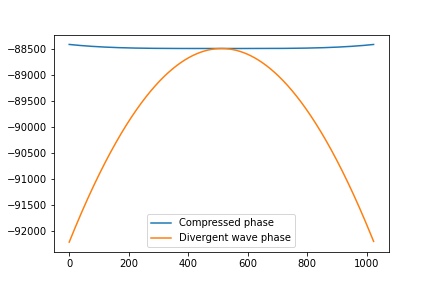

The maximum phase difference in the original input was 14.19 rad, with CSW it's 0.59 rad.


<IPython.core.display.Javascript object>


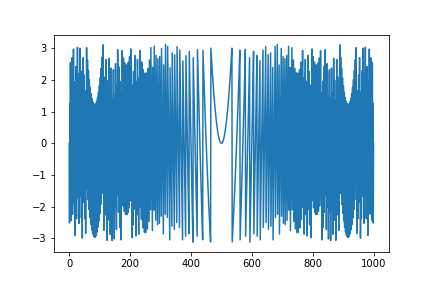

<IPython.core.display.Javascript object>


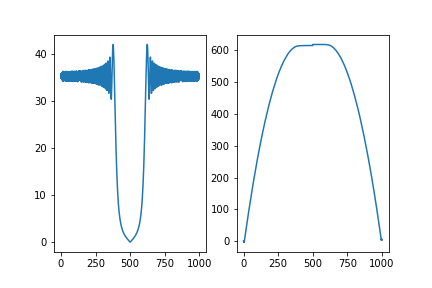

Phase at f=0 : 1.03362708593472


In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 

zo = 5e-3
pixel = 20e-6
N = 1024
m = 7
x1 = np.arange(-int(N/2), int(N/2)) * pixel / m
wavelength = 355e-9

phase_spherical = -2*np.pi/wavelength * np.sqrt(zo**2 + x1**2)
phase_paraxial = 1*np.pi/wavelength/zo*x1**2
phase = phase_spherical + phase_paraxial

fig1, ax1 = plt.subplots()
ax1.plot(phase, label='Compressed phase')
ax1.plot(phase_spherical, label='Divergent wave phase')
ax1.legend()

dp_max = np.max(np.abs(np.diff(phase_spherical)))
dpc_max = np.max(np.abs(np.diff(phase)))
print(f"The maximum phase difference in the original input was {dp_max:.2f} rad, with CSW it's {dpc_max:.2f} rad.")

# Chirp example
x = np.linspace(-1, 1, 1000)
a = 100
chirp = np.exp(2j*np.pi*x**2 * a)
fig2, ax2 = plt.subplots()
ax2.plot(np.angle(chirp))

fig3, ax3 = plt.subplots(1, 2)
f_chirp = np.fft.fft(chirp)
ax3[0].plot(np.abs(f_chirp))
ax3[1].plot(np.unwrap(np.angle(f_chirp)))
plt.show()
print(f'Phase at f=0 : {np.angle(f_chirp[500])}')

### Zero padding

The use of a paraxial approximation for compressing a defocused signal that can be compressed to SW when using a non-paraxial spherical wave, gives an upper limit in frequency
$$f_{l1}(x_1) = x_1 \lambda^{-1}(z_1^2+x_1^2)^{-\frac{1}{2}} - x_1\lambda^{-1} z_{c1}^{-1} + \frac{B_{f_1}^\lim}{2}$$

$B_{f1} = 2\max(f_{l1}(x_1))$, with $x_1 \in [-B_{x_1}^\lim/2, B_{x_1}^\lim/2)$, and the maximum is reached at
$$x_1 = \sqrt{(z_{c1}z_1^2)^{2/3} - z_1^2}.$$

The CSW-ASM first uses a chirp that introduces a spatial shift $\lambda z_{c1}B_{f_1}^\lim$ that extends $B_{x_1}^\lim$. Then
$$f_{l1}^{(1)}(x_1) = f_{l1}(x_{s1}) = f_{l1}(x_1 - \lambda z_{c1} f_{l1}(x_1)).$$

$H_c$ applied on $f_2$, requires an extended $x_2$:
$$x_{l2}(f_{s2}) = \lambda z_{c1}f_{l1}(\lambda z_{c1}f_{s2}) + \frac{z f_{s2}}{\sqrt{\lambda^{-2} - f_{s2}^2}} + \lambda z_cf_{s2},$$
where $f_{s2} = x_{s1}/\lambda z_{c1}$, $z = z_1 + z_2$ (first propagates towards source), and $z_c = z_{c1} + z_{c2}$. The first term is the previous sheared GSW and the other two are due to $H_c$. The effect of $H_c$ is equivalently considered at $x_1=\lambda z_{c1}f_2$ or $f_1 = x_2/(\lambda z_{c1})$, which gives a new $B_{f1}^{(2)}$ or
$$f_{l1}^{(2)}(x_1) = \lambda^{-1}z_{c1}^{-1} x_{l2}(\lambda z_{c1}f_{s2})$$

The chirp in $f_3$, using a spatial extent of $f_{l3}(x_3)=x_{l2}/(\lambda z_{c2})$, extends the required domain in $x_3$ as
$$x_{s3} = -m x_{s1} + x_{l2}(f_{s2}),$$
where the first term is due to the scaling of the spatial domain from input to output, and the second term is the shearing. Finally, these requirements are considered at the input:
$$f_{l1}^{(3)}(x_1) = mf_{l3}(x_{s3}/m) = f_{l3}(x_{s3}/m)/(\lambda z_{c1}) \mbox{, and } x_3=mx_1$$

If $z_{c1}$ was chosen different from $z_1$, then $z_{c2} = z_{c1}\frac{z_2}{z_1}.$

Gibbs errors are reduced by extending $B_{f_1}'$ more than is required (30%).